# Week 6 Practical - Question 1 Solution
Consider the EigenFaces example from the Week 6 Lecture (CAB420_Week6_Ex5_Eigenfaces.mlx). Using this example, and the PCA space that is learned on the YaleB Face Dataset, investigate the face recognition performance of two additional datasets:
* Yale_32x32.mat; and
* ORL_32x32.mat. 

For each of these you should:
* Use the PCA space learned on the YaleB data (i.e. don't learn a different PCA space on the new data);
* Ensure that the new data is resized to the same size as the YaleB data prior to use;
* Train a simple KNN classifier, using roughly 66\% of the data as training, and the rest as testing;
* Evaluate the accuracy of the predictions with different numbers of components retained;
* Visually inspect reconstructions with different numbers of components retained, and comment on the quality of the reconstructions for the two databases.

In [13]:
import numpy
import numpy.matlib
import scipy
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## Part 1: Preliminaries
Load data, compute PCA space, etc. As per last week's example.

This is an abbreviated version of the lecture example.

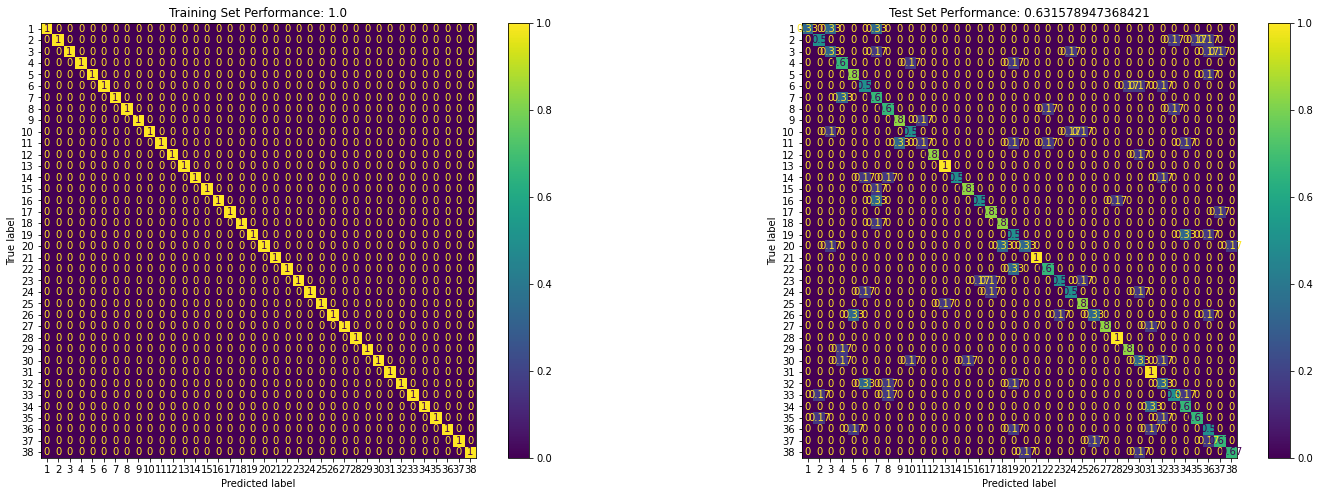

In [14]:
yale_b = scipy.io.loadmat('../../data/YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd'])

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

pca = decomposition.PCA()
pca.fit(train_fea)
transformed = pca.transform(train_fea)
transformed_test = pca.transform(test_fea)

cumulative_sum = numpy.cumsum(pca.explained_variance_ratio_, axis=0)
top95 = numpy.where(cumulative_sum > 0.95)[0][0]

transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));
    
cknn_95 = KNeighborsClassifier(n_neighbors=10, weights='distance')
cknn_95.fit(transformed_train_95, train_gnd)
eval_model(cknn_95, transformed_train_95, train_gnd, transformed_test_95, test_gnd)    

## ORL Database
First up we'll look at the ORL database. 

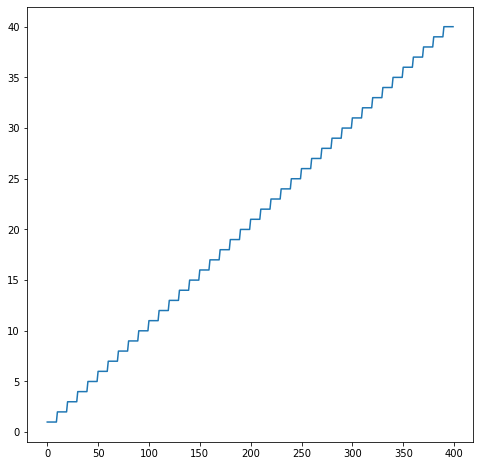

In [15]:
orl = scipy.io.loadmat('../../data/ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(gnd)

Our data has 40 subjects, each with 10 images

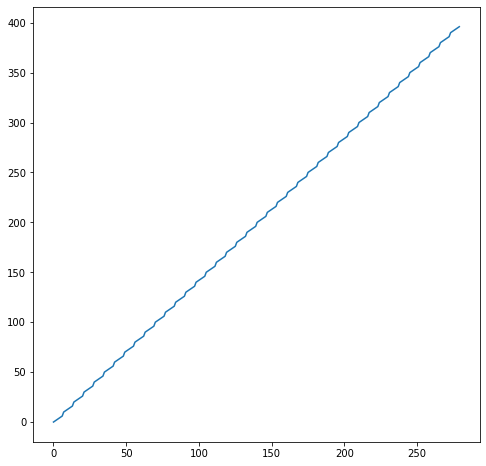

In [16]:
train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_frames);

In [17]:
train_orl_fea = fea[train_frames, :]
train_orl_gnd = gnd[train_frames, :]
test_orl_fea = fea
test_orl_gnd = gnd
test_orl_fea = numpy.delete(test_orl_fea, train_frames, 0)
test_orl_gnd = numpy.delete(test_orl_gnd, train_frames, 0)
train_orl_gnd = numpy.reshape(train_orl_gnd, -1)
test_orl_gnd = numpy.reshape(test_orl_gnd, -1)
print(numpy.shape(train_orl_fea))
print(numpy.shape(train_orl_gnd))
print(numpy.shape(test_orl_fea))
print(numpy.shape(test_orl_gnd))

(280, 1024)
(280,)
(120, 1024)
(120,)


Before we get into face rec, inspect the reconstructions.

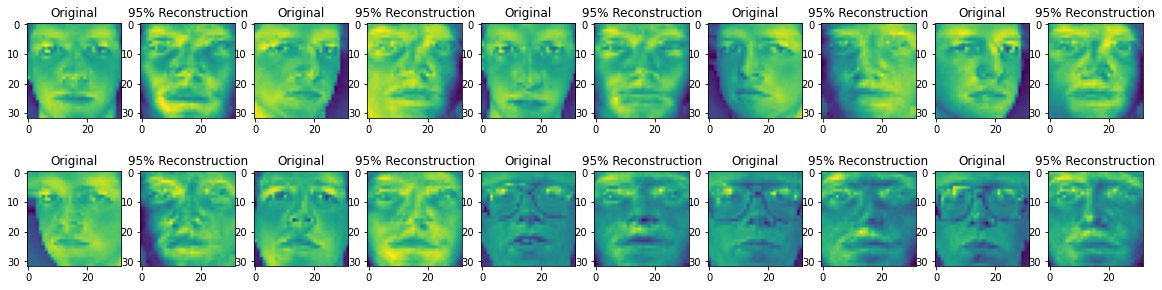

In [18]:
transformed = pca.transform(train_orl_fea)
transformed_test = pca.transform(test_orl_fea)
transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

fig = plt.figure(figsize=[20, 5])
count = 0
for i in range(5):
    for j in range(2):
        ax = fig.add_subplot(2, 10, count*2 + 1)
        ax.imshow(numpy.reshape(train_orl_fea[count,:] - pca.mean_, (32, 32)).transpose())
        ax.set_title('Original');

        ax = fig.add_subplot(2, 10, count*2 + 2)
        ax.imshow(numpy.reshape(pca.components_[0:top95,:].transpose().dot(numpy.reshape(transformed[count,0:top95], (-1, 1))), (32, 32)).transpose())
        ax.set_title('95% Reconstruction');
        count += 1

It's fair to say, they're pretty ordinary, certainly compared to our YaleB data. Why are they so crap? There's one main reason:
* We have a disconnect between the conditions in YaleB and ORL, so the model has learned the "important components" in slightly different conditions.

These changes can be many things, like changes in lighting, pose, resolution, how faces were cropped, etc. All of these contribute to the less than perfect reconstructions.

On to classifier training. For simplicity, we'll repeat the optimised cknn training.

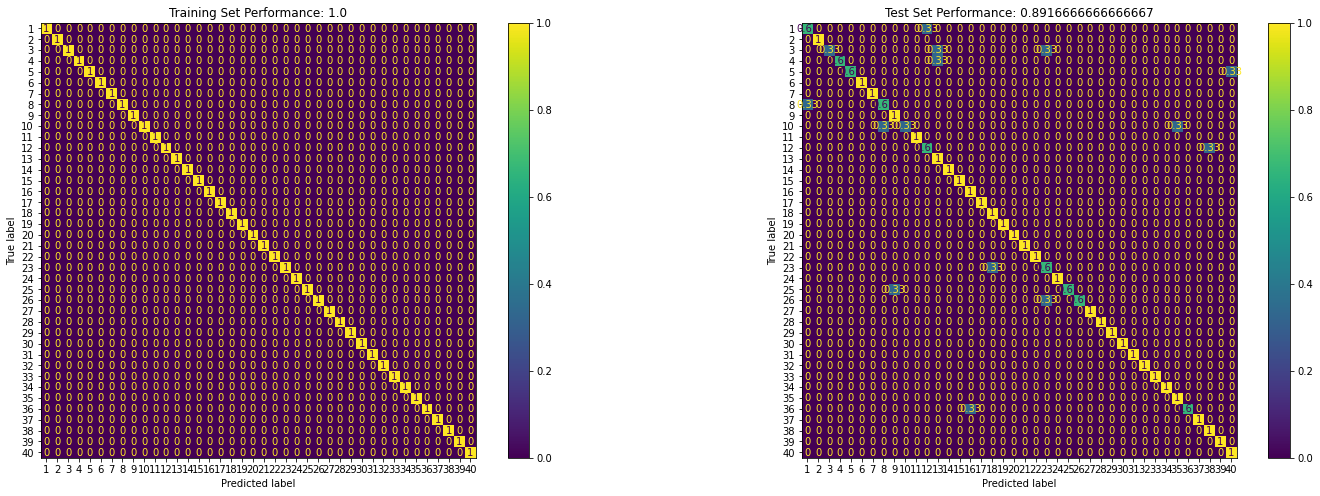

In [19]:
cknn_95 = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_95.fit(transformed_train_95, train_orl_gnd)
eval_model(cknn_95, transformed_train_95, train_orl_gnd, transformed_test_95, test_orl_gnd)    

And in the end it works pretty well, despite the poor reconstrutions.

## Yale Dataset

This is the dataset prior to YaleB, it's much smaller and doesn't have the same level of lighting variation.

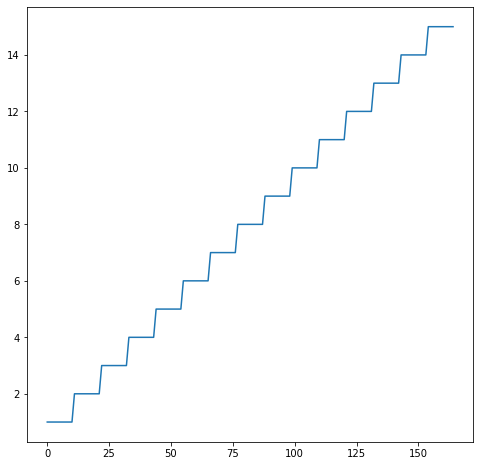

In [20]:
yale = scipy.io.loadmat('../../data/Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])
fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(gnd)

Our data has 15 subjects, each with 11 images

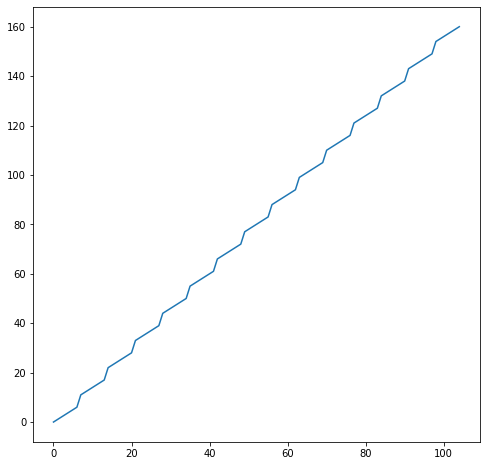

In [21]:
train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_frames);

In [22]:
train_yale_fea = fea[train_frames, :]
train_yale_gnd = gnd[train_frames, :]
test_yale_fea = fea
test_yale_gnd = gnd
test_yale_fea = numpy.delete(test_yale_fea, train_frames, 0)
test_yale_gnd = numpy.delete(test_yale_gnd, train_frames, 0)
train_yale_gnd = numpy.reshape(train_yale_gnd, -1)
test_yale_gnd = numpy.reshape(test_yale_gnd, -1)
print(numpy.shape(train_yale_fea))
print(numpy.shape(train_yale_gnd))
print(numpy.shape(test_yale_fea))
print(numpy.shape(test_yale_gnd))

(105, 1024)
(105,)
(60, 1024)
(60,)


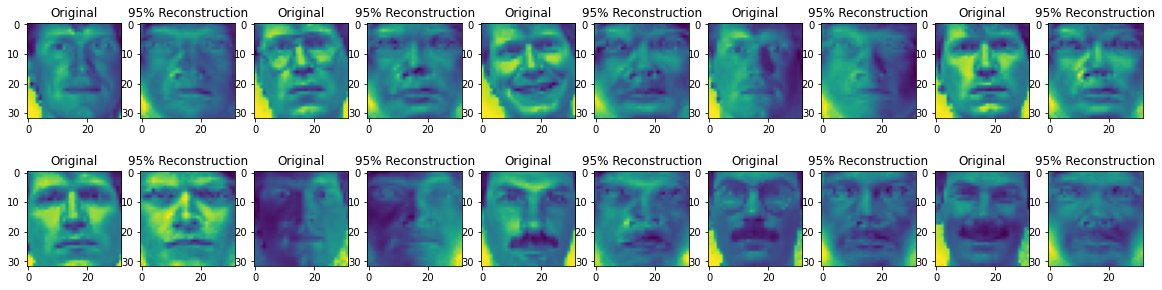

In [23]:
transformed = pca.transform(train_yale_fea)
transformed_test = pca.transform(test_yale_fea)
transformed_train_95 = transformed[:, 0:top95]
transformed_test_95 = transformed_test[:, 0:top95]

fig = plt.figure(figsize=[20, 5])
count = 0
for i in range(5):
    for j in range(2):
        ax = fig.add_subplot(2, 10, count*2 + 1)
        ax.imshow(numpy.reshape(train_yale_fea[count,:] - pca.mean_, (32, 32)).transpose())
        ax.set_title('Original');

        ax = fig.add_subplot(2, 10, count*2 + 2)
        ax.imshow(numpy.reshape(pca.components_[0:top95,:].transpose().dot(numpy.reshape(transformed[count,0:top95], (-1, 1))), (32, 32)).transpose())
        ax.set_title('95% Reconstruction');
        count += 1

As with ORL, our reconstructions are not good. The reasons are much the same as with ORL.

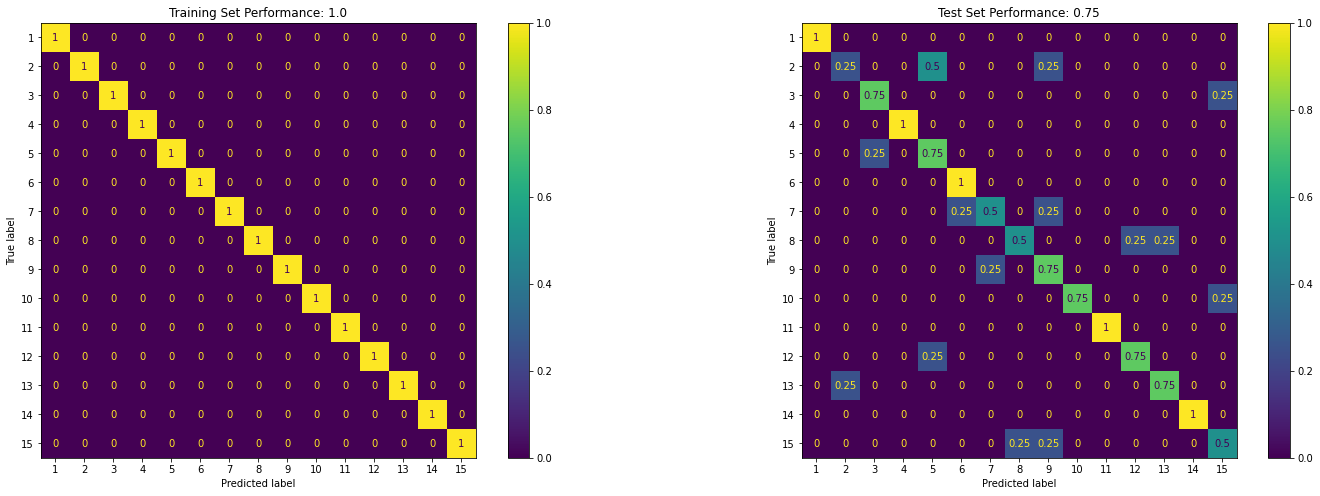

In [24]:
cknn_95 = KNeighborsClassifier(n_neighbors=3, weights='distance')
cknn_95.fit(transformed_train_95, train_yale_gnd)
eval_model(cknn_95, transformed_train_95, train_yale_gnd, transformed_test_95, test_yale_gnd)    

Classification is a bit worse here, but not terrible again.

## Thoughts and Remarks
* Reconstructions performance seems to suffer more than classification performance, but classification would be better with a subspace trained on the actual data
* The small size of the database, and the large-ish training set helps mask this
* If you try running with fewer components, you'll see performance on the other databases suffers more. The more components we retain, the more likely it is we get the critical information.
* Another, largely unrelated, thing you may have noticed: most of the subjects in the face data are white men. This is a large problem in machine learning, most of our training sets are heavily biased. These datasets were all collected in and around the labs where the work was done, and the labs are male dominated - hence the imbalance. However this has real issues as these systems become more widely used, face rec systems for example are more accurate on white men for example than black women, simply becuase there's more training data for the former. This is a big problem for many datasets and tasks which has not yet been addressed.